# Automatic BSPF AnalysisData

Creates automatic event plots based on catalog 

In [256]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from pprint import pprint

from functions.request_data import __request_data
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.compute_adr_pfo import __compute_adr_pfo


In [257]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [258]:
def __process_xpfo(config, st, inv):

    ii_pfo = st.copy()

#     pre_filt = [0.005, 0.01, 19, 20]

    ## cut properly
#     ii_pfo.trim(config['tbeg'], config['tend'])

    ## demean
    ii_pfo.detrend("demean")

    ## remove response
#     ii_pfo.remove_response(inventory=inv, 
#     #                        pre_filt=pre_filt, 
#                            output="VEL",
#     #                        water_level=60, 
#                            plot=False)

    ## taper 
    ii_pfo.taper(0.1)

    ## bandpass
    ii_filter = ii_pfo.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

    ## adjust channel names
    for tr in ii_pfo:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","N")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","E")
    
    return ii_pfo

In [259]:
def __makeplot(config, st):

    
    st_in = st.copy()
    
    fig, ax = plt.subplots(6,1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1e9
    trans_scaling = 1e6
    
    for i, tr in enumerate(st_in):
        
        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)
            
        ax[i].legend(loc=1)
        
    ax[5].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)
    
    plt.show();
    del st_in
    return fig

In [260]:
def __makeplotStreamSpectra2(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    st_in = st.copy()
    
    NN = len(st_in)
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
        
    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    font = 14
    
    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st_in):

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling

        spec, ff, ph = __fft(tr.data*scaling, tr.stats.delta, window=None, normalize=None)
    
    
        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )

        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
        ## _________________________________________________________________
        if fscale == "loglog":
            axes[i,1].loglog(ff, spec, color='black', lw=1.0)
        elif fscale == "loglin":
            axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
        elif fscale == "linlog":
            axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
        else:
            axes[i,1].plot(ff, spec, color='black', lw=1.0)         
        
        
        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", trans_unit
        else:
            unit = "Amplitude", "a.u."
            
        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)    
        axes[i,1].set_ylabel(f'ASD \n({unit}/Hz)',fontsize=font)        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    if "fmin" in config.keys() and "fmax" in config.keys():
        axes[i,1].set_xlim(config['fmin'],config['fmax'])

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)     
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)",fontsize=font)     

    del st_in
    return fig

In [261]:
def __empty_stream(reference_stream):

    from numpy import ones
    from obspy import Stream, Trace
    
    t_ref = reference_stream[0]
    
    empty = Stream()

    for cha in ["BHZ", "BHN", "BHE"]:
        t = Trace()
        t.data = ones(len(t_ref))
        t.stats.sampling_rate = t_ref.stats.sampling_rate
        t.stats.starttime = t_ref.stats.starttime
        t.stats.network, t.stats.station, t.stats.channel = "PY", "RPFO", cha
        empty += t
        
    return empty

In [262]:
def __stream_to_dataframe(st):
    
    dff = pd.DataFrame()

    for tr in st: 
        name = f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel}"
        dff[name] = tr.data
        
    return dff

## Configurations

In [263]:
config = {}

## location of BSPF
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## path for figures to store
# config['outpath_figs'] = data_path+"BSPF/figures/triggered_all/"

## path for output data
config['outpath_data'] = data_path+"BSPF/data/" 

config['path_to_mseed'] = data_path+"BSPF/data/waveforms/" 

## blueSeis sensor (@200Hz)
# config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier (@40Hz)
# config['seed_seismometer1'] = "II.PFO.10.BH*" 

## STS2 next to BlueSeis (@200Hz)
# config['seed_seismometer2'] = "PY.PFOIX..HH*" 

config['path_to_catalog'] = data_path+"BSPF/data/catalogs/"

config['catalog'] = "BSPF_catalog_20221001_20230615_triggered.pkl"

## Event Info

In [315]:
events = pd.read_pickle(config['path_to_catalog']+config['catalog'])

## add column for hypocenter distance
events['Hdistance_km'] = np.sqrt(events['distances_km']**2+(events['depth']/1000)**2)
events

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km,Hdistance_km
0,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:10.344538Z,2022-10-01T05:36:15.816780Z,2022-10-01T05:36:11.240000Z,4.0,19.684030,14.252022,16.920240
1,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.694538Z,2022-10-01T21:26:55.332138Z,2022-10-01T21:26:43.530000Z,6.0,147.912150,48.053535,50.379154
2,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,98716.44,2022-10-02T03:25:19.269538Z,2022-10-02T03:25:20.869968Z,2022-10-02T03:25:16.440000Z,6.0,19.364710,14.850966,16.887652
3,2022-10-02 15:51:37.180,33.480167,-116.398000,8240.0,1.68,ml,143497.18,2022-10-02T15:51:37.444539Z,2022-10-02T15:51:41.755137Z,2022-10-02T15:51:37.180000Z,6.0,339.780826,15.423592,17.486703
4,2022-10-02 21:52:54.280,33.485333,-116.509333,9650.0,0.99,ml,165174.28,2022-10-02T21:52:57.394539Z,2022-10-02T21:52:59.069507Z,2022-10-02T21:52:54.280000Z,6.0,19.790278,14.772415,17.645021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,2023-06-05 17:22:59.900,33.992667,-116.609167,15140.0,0.91,ml,21403379.90,2023-06-05T17:23:13.670000Z,2023-06-05T17:23:11.132115Z,2023-06-05T17:22:59.900000Z,4.0,161.387898,44.700753,47.195094
278,2023-06-05 17:23:05.920,33.992667,-116.612500,14750.0,1.95,ml,21403385.92,2023-06-05T17:23:13.670000Z,2023-06-05T17:23:17.078772Z,2023-06-05T17:23:05.920000Z,4.0,161.012766,44.800001,47.165693
279,2023-06-07 06:03:42.030,33.965667,-116.946000,7240.0,2.58,ml,21535422.03,2023-06-07T06:03:52.040000Z,2023-06-07T06:03:54.073220Z,2023-06-07T06:03:42.030000Z,6.0,130.780515,60.123060,60.557410
280,2023-06-11 02:38:25.290,33.604000,-116.628000,13450.0,1.12,ml,21868705.29,2023-06-11T02:38:28.860000Z,2023-06-11T02:38:31.166238Z,2023-06-11T02:38:25.290000Z,6.0,87.318065,16.031930,20.926665


## RUN LOOP

In [316]:
def __compute_Amax(st_in, out_lst):
     
    st_in = st_in.sort()

    st_in = st_in.detrend("linear")
    
    out, header = [], []
    for tr in st_in:
        out.append(max(abs(tr.data)))
        
        if tr.stats.station[:3] == "PFO":
            header.append(f"PFO_{tr.stats.location}_{tr.stats.channel[-1]}_amax")
        else:
            header.append(f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel[-1]}_amax")
        
    out_lst.append(out)
    return out_lst, header

In [317]:
def __compute_SNR(st_in, out_lst, trigger_time, win_length_sec=10, plot=False):

    from numpy import nanmean, sqrt
    from obspy import UTCDateTime
    
    st_in = st_in.sort()
    
    if plot:
        fig, ax = plt.subplots(len(st_in),1, figsize=(15,15))
    
    out, header = [], []
    for i, tr in enumerate(st_in):

        t_rel_sec = UTCDateTime(trigger_time)-tr.stats.starttime
        
        df = tr.stats.sampling_rate 

        NN = int(df * win_length_sec) ## samples

        t_rel_spl = t_rel_sec*df ## samples

        t_offset = df * 2 ## samples

        noise = nanmean(tr.data[int(t_rel_spl-NN):int(t_rel_spl)]**2)
        signal = nanmean(tr.data[int(t_rel_spl):int(t_rel_spl+NN)]**2)

        out.append(sqrt(signal/noise))
        if tr.stats.station[:3] == "PFO":
            header.append(f"PFO_{tr.stats.location}_{tr.stats.channel[-1]}_snr")
        else:
            header.append(f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel[-1]}_snr")
            
        if plot:
            ax[i].plot(tr.data)

            ax[i].axvline(t_rel_spl, color="red")
            ax[i].axvline(t_rel_spl+NN, color="red")

            ax[i].axvline(t_rel_spl, color="g")
            ax[i].axvline(t_rel_spl-NN, color="g")
        
    out_lst.append(out)
    
    return out_lst, header

In [318]:
def __add_radial_and_transverse_channel(st_in, sta, baz):
    
    from obspy import Trace
    from obspy.signal.rotate import rotate_ne_rt

    st_acc = st_in.select(station=sta).copy()
    
    r_acc, t_acc = rotate_ne_rt(st_acc.select(channel='*N')[0].data, 
                                st_acc.select(channel='*E')[0].data,
                                baz
                                )
    
    
    tr_r = st_acc[0].copy()
    tr_r.data = r_acc
    tr_r.stats.channel = tr_r.stats.channel[:-1]+"R"
    
    tr_t = st_acc[0].copy()
    tr_t.data = t_acc
    tr_t.stats.channel = tr_t.stats.channel[:-1]+"T"
    
    st_in += tr_r
    st_in += tr_t
    
    return st_in

In [319]:
config['mseed_files'] = sorted([file for file in os.listdir(config['path_to_mseed'])])

In [329]:

## create dataframe for output
out_df = pd.DataFrame()

out_df["Torigin"] = events.origin
out_df["Magnitude"] = events.magnitude
out_df["CoincidenceSum"] = events.cosum
out_df["BAZ"] = events.backazimuth
out_df["Edistance"] = events.distances_km
out_df["Hdistance"] = events.Hdistance_km

tmp = [str(ee).split(".")[0] for ee in events.origin]

data_amax, data_snr, skipped, jj = [], [], 0, 0
for event in config['mseed_files']:

    yy = int(event.replace(".","_").split("_")[1][:4])
    mm = int(event.replace(".","_").split("_")[1][4:6])
    dd = int(event.replace(".","_").split("_")[1][6:8])
    h = int(event.replace(".","_").split("_")[2][0:2])
    m = int(event.replace(".","_").split("_")[2][2:4])
    s = int(event.replace(".","_").split("_")[2][4:6])

    otime = f"{yy}-{mm:02d}-{dd:02d} {h:02d}:{m:02d}:{s:02d}"
            
    if otime not in tmp:
        skipped += 1
        continue
    else:
        jj += 1
        

    print(f"\n -> {jj} {events.origin[jj]} ")
    
    event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]
    

    st = obs.read(config['path_to_mseed']+event)

    ## add radial and transverse channels
    st = __add_radial_and_transverse_channel(st, "PFO*", events.backazimuth[jj])
    st = __add_radial_and_transverse_channel(st, "BSPF", events.backazimuth[jj])
    
    
    ## processing data stream
    st = st.detrend("linear")
    st = st.taper(0.01)
    st = st.filter("highpass", freq=0.01, corners=4, zerophase=True)
    
    
    ## compute maximal amplitude values (PGA and PGR)
    data_amax, header_amax = __compute_Amax(st, data_amax)

    ## compute signal-to-noise ratios
    data_snr, header_snr = __compute_SNR(st, data_snr, events.trigger_time[jj], win_length_sec=5)
    

    
## _______________________________________

df_amax = pd.DataFrame(columns=header_amax)

for i, row in enumerate(data_amax):
    if len(row) == len(st):
        df_amax.loc[len(df_amax)] = row
    else:
        df_amax.loc[len(df_amax)] = np.ones(len(st))*np.nan

df_amax_out = pd.concat([out_df, df_amax], axis=1, ignore_index=False, sort=False)

df_amax_out.to_pickle(config['outpath_data']+"bspf_analysisdata_amax.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_amax.pkl")

## _______________________________________ 
    
df_snr = pd.DataFrame(columns=header_snr)


for row in data_snr:
    if len(row) == len(st):
        df_snr.loc[len(df_snr)] = row    
    else:
        df_snr.loc[len(df_snr)] = np.ones(len(st))*np.nan

df_snr_out = pd.concat([out_df, df_snr], axis=1, ignore_index=False, sort=False)

df_snr_out.to_pickle(config['outpath_data']+"bspf_analysisdata_snr.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_snr.pkl")

print(f"\n -> skipped: {skipped}")

## End of File


 -> 1 2022-10-01 21:26:43.530000 

 -> 2 2022-10-02 03:25:16.440000 

 -> 3 2022-10-02 15:51:37.180000 

 -> 4 2022-10-02 21:52:54.280000 

 -> 5 2022-10-03 09:17:36.890000 


/home/brotzer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/brotzer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice



 -> 6 2022-10-03 16:08:09.970000 

 -> 7 2022-10-04 22:33:48.370000 

 -> 8 2022-10-05 15:39:32.640000 
2022-10-05 15:39:13

 -> 9 2022-10-07 22:45:05.470000 
2022-10-05 15:42:03
2022-10-05 18:35:16

 -> 10 2022-10-08 02:52:33.350000 

 -> 11 2022-10-08 02:59:39.290000 

 -> 12 2022-10-09 08:33:00.550000 

 -> 13 2022-10-09 11:44:41.790000 

 -> 14 2022-10-09 17:51:16.290000 

 -> 15 2022-10-11 14:54:34.260000 
2022-10-10 05:48:52

 -> 16 2022-10-14 03:49:02.940000 
2022-10-12 19:12:14
2022-10-12 23:08:11
2022-10-12 23:58:00
2022-10-14 03:13:56

 -> 17 2022-10-15 05:17:34.150000 

 -> 18 2022-10-17 05:25:28.830000 
2022-10-16 08:42:24

 -> 19 2022-10-19 08:38:25.820000 

 -> 20 2022-10-21 08:53:10.210000 

 -> 21 2022-10-22 17:23:29.270000 

 -> 22 2022-10-23 09:24:58.150000 

 -> 23 2022-10-24 12:13:57.370000 

 -> 24 2022-10-24 15:39:11.390000 

 -> 25 2022-10-24 23:19:02.470000 

 -> 26 2022-10-25 03:55:30.970000 

 -> 27 2022-10-25 12:29:41.420000 

 -> 28 2022-10-26 02:14:58.1300


 -> 213 2023-04-26 06:46:58.450000 

 -> 214 2023-04-27 02:18:01.040000 

 -> 215 2023-04-27 10:01:52.470000 

 -> 216 2023-04-27 23:10:52.560000 

 -> 217 2023-04-28 18:53:01.930000 

 -> 218 2023-04-28 18:53:05.460000 

 -> 219 2023-04-29 00:27:39.340000 

 -> 220 2023-04-29 21:23:33.630000 

 -> 221 2023-04-30 05:55:59.950000 

 -> 222 2023-04-30 07:26:56.390000 
2023-05-01 02:52:56

 -> 223 2023-04-30 07:27:16.590000 

 -> 224 2023-04-30 07:27:20.170000 

 -> 225 2023-04-30 22:11:15.960000 

 -> 226 2023-05-01 13:49:05.710000 

 -> 227 2023-05-01 20:36:51.480000 

 -> 228 2023-05-01 21:44:44.310000 

 -> 229 2023-05-03 01:43:20.780000 

 -> 230 2023-05-03 19:56:58.660000 

 -> 231 2023-05-03 21:14:20.210000 

 -> 232 2023-05-05 21:42:19.180000 

 -> 233 2023-05-06 02:18:54.790000 

 -> 234 2023-05-09 02:22:07.210000 

 -> 235 2023-05-09 03:01:09.100000 

 -> 236 2023-05-09 03:01:11.250000 

 -> 237 2023-05-10 19:48:55.040000 

 -> 238 2023-05-10 20:20:14.660000 

 -> 239 2023-05-1

## Tests

In [330]:
def __rolling_average(arr, win_size=5):
    
    from numpy import ones, array
    from scipy.signal import convolve, hanning
    
    data = array(arr)
    window = ones(win_size)/float(win_size)
    window = hanning(win_size)/float(win_size)
    rolling_average = convolve(data, window, mode='valid')

    return rolling_average

In [779]:
## load data
st = obs.read(config['path_to_mseed']+config['mseed_files'][20])

## add radial and transverse channels
st = __add_radial_and_transverse_channel(st, "PFO*", events.backazimuth[jj])
st = __add_radial_and_transverse_channel(st, "BSPF", events.backazimuth[jj])

## processing data stream
st = st.detrend("linear")
st = st.taper(0.01)
st = st.filter("highpass", freq=5.0, corners=4, zerophase=True)


baz = out_df.loc[jj].BAZ

from obspy.signal.rotate import rotate_ne_rt

st

st_acc = st.select(station="PFO*").copy()
st_rot = st.select(station="BSPF").copy()

# st_acc.filter("bandpass", freqmin=10, freqmax=18, zerophase=True, corners=4)
# st_rot.filter("bandpass", freqmin=10, freqmax=18, zerophase=True, corners=4)

r_acc, t_acc = rotate_ne_rt(st_acc.select(channel='*N')[0].data, 
                            st_acc.select(channel='*E')[0].data,
                            baz
                            )

r_rot, t_rot = rotate_ne_rt(st_rot.select(channel='*N')[0].data, 
                            st_rot.select(channel='*E')[0].data,
                            baz
                            )

df = st_acc[0].stats.sampling_rate


z_acc = st_acc.select(channel="*Z")[0].data

16 Trace(s) in Stream:
II.PFO.10.BHE  | 2022-10-12T19:11:14.669536Z - 2022-10-12T19:14:14.669536Z | 40.0 Hz, 7201 samples
II.PFO.10.BHN  | 2022-10-12T19:11:14.669536Z - 2022-10-12T19:14:14.669536Z | 40.0 Hz, 7201 samples
II.PFO.10.BHZ  | 2022-10-12T19:11:14.669536Z - 2022-10-12T19:14:14.669536Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJE | 2022-10-12T19:11:14.669536Z - 2022-10-12T19:14:14.669536Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJN | 2022-10-12T19:11:14.669536Z - 2022-10-12T19:14:14.669536Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJZ | 2022-10-12T19:11:14.669536Z - 2022-10-12T19:14:14.669536Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJE | 2022-10-12T19:11:14.669536Z - 2022-10-12T19:14:14.669536Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJN | 2022-10-12T19:11:14.669536Z - 2022-10-12T19:14:14.669536Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJZ | 2022-10-12T19:11:14.669536Z - 2022-10-12T19:14:14.669536Z | 40.0 Hz, 7201 samples
PY.BSPF..HJE   | 2022-10-12T19:11:14.674100Z - 2022-10-12T19:14:14.674100Z | 40.0 Hz, 

In [780]:
def __velocity_from_amplitude_ratio(rot, acc, df, win_time_s=2.0, cc_thres=0.8, overlap=0.5, plot=False):
    
    from scipy.stats import pearsonr
    from numpy import zeros, nan, ones, nanmean, array, nanmax, linspace, std
    from scipy import odr
    from functions.compute_linear_regression import __compute_linear_regression
    
    npts = len(rot)
    
    ## windows
    t_win = win_time_s
    n_win = int(win_time_s*df)
    nover = int(0.5*n_win)
        
    ## define windows
    n, windows = 0, []
    while n < npts:
        windows.append((n,n+n_win))        
        n+=n_win
        
        
    ## add overlap
    windows_overlap = []
    for i, w in enumerate(windows):
        if i == 0:
            windows_overlap.append((w[0],w[1]+nover))
        elif i >= (len(windows)-nover):
            windows_overlap.append((w[0]-nover, w[1]))
        else:
            windows_overlap.append((w[0]-nover, w[1]+nover))
    
    vel, ccor = ones(len(windows_overlap))*nan, zeros(len(windows_overlap))
    
    ## compute crosscorrelation for each window
    for j, (w1, w2) in enumerate(windows_overlap):
        
        ## trying to remove very small rotation values
#         rot_win = array([r if r>5e-8 else 0 for r in rot[w1:w2]])
#         acc_win = array([a if r>5e-8 else 0 for a, r in zip(acc[w1:w2], rot[w1:w2])])
    
        rot_win, acc_win = rot[w1:w2], acc[w1:w2]

        if len(rot_win) < 10: 
            print(f" -> not enough samples in window (<10)")
            
#         ccor[j], p = pearsonr(rot_win/nanmax(abs(rot_win)), acc_win/nanmax(abs(acc_win)))
        ccor[j], p = pearsonr(rot_win, acc_win)
        
        ## if cc value is above threshold perform odr to get velocity
        if ccor[j] > cc_thres:
            data = odr.RealData(rot_win, acc_win)
            out = odr.ODR(data, model=odr.unilinear)
            output = out.run()
            slope, intercept = output.beta
            vel[j] = abs(slope)

            
    ## define time axis
    time = [((w2-w1)/2+w1)/df for (w1, w2) in windows_overlap]

#     print(len(time), len(ccor), len(vel))
    
    if plot:
        
        cmap = plt.get_cmap("viridis", 10)
        
        fig, ax = plt.subplots(1,1,figsize=(15,5))
        
        ax.plot(array(range(len(rot)))/df, rot/max(abs(rot)), alpha=1, color="grey", label="rotation rate (rad/s)")
        ax.plot(array(range(len(acc)))/df, acc/max(abs(acc)), alpha=0.5, color="tab:red", label="acceleration (m/s)")
        
        
        ax.set_ylim(-1,1)
        ax.set_xlim(0, len(rot)/df)
        ax.set_xlabel("Time (s)",fontsize=14)
        ax.set_ylabel("Norm. Amplitude",fontsize=14)
        ax.grid(zorder=0)
        ax.legend(fontsize=13)
        
        ax2 = ax.twinx()
        cax = ax2.scatter(time, vel, c=ccor, s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1)
        ax2.set_ylabel("Phase Velocity (m/s)", fontsize=14)
        ax2.set_ylim(bottom=0)
        ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
        
        cbar = plt.colorbar(cax, pad=0.08)
        cbar.set_label("Cross-Correlation Coefficient", fontsize=14)
        
        cax.set_clip_on(False)
        
    return time, vel, ccor

 -> not enough samples in window (<10)


160.32306529547279

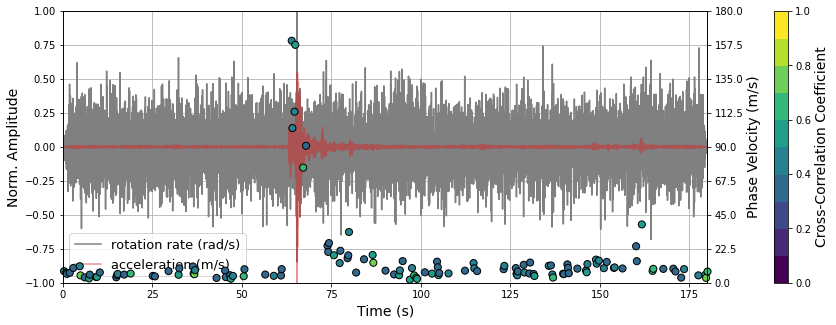

In [783]:
t, velocities, ccor = __velocity_from_amplitude_ratio(t_rot, z_acc, df, win_time_s=.2, cc_thres=0.3, overlap=0.5, plot=True)

np.nanmax(velocities)

-20


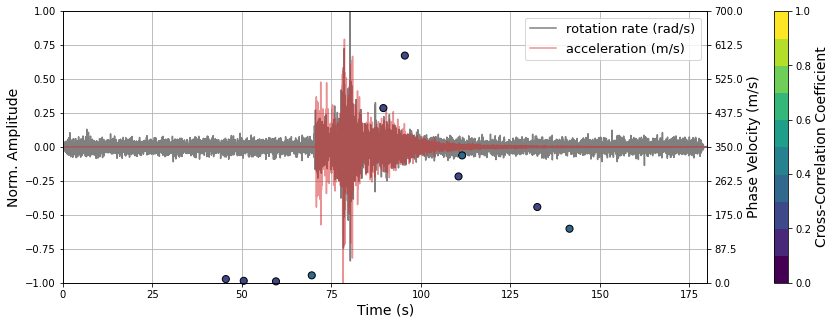

-19


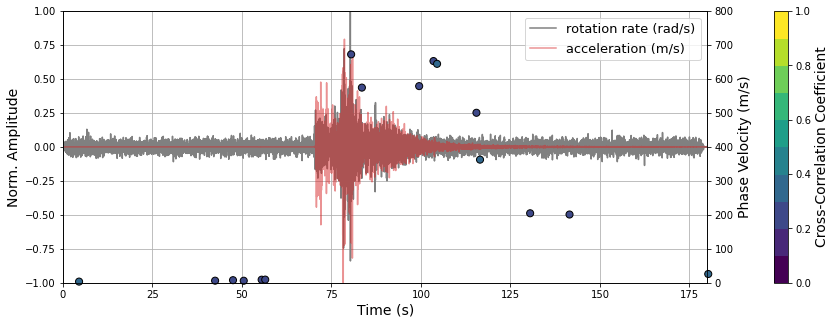

-18


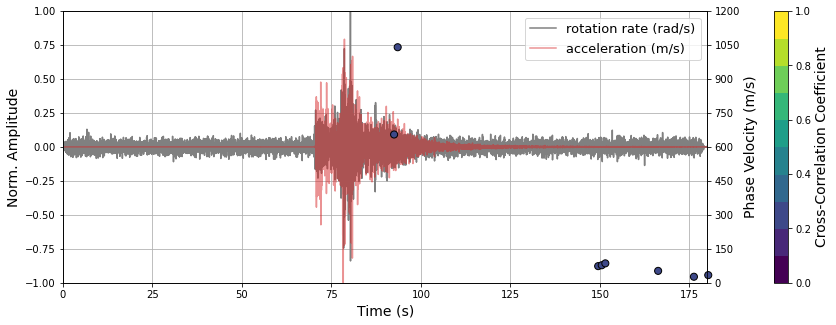

-17


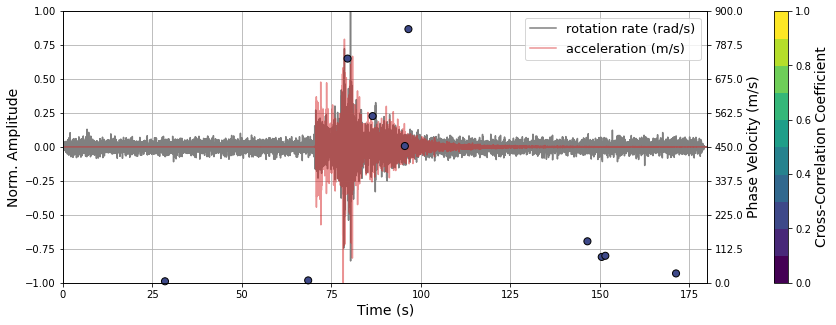

-16


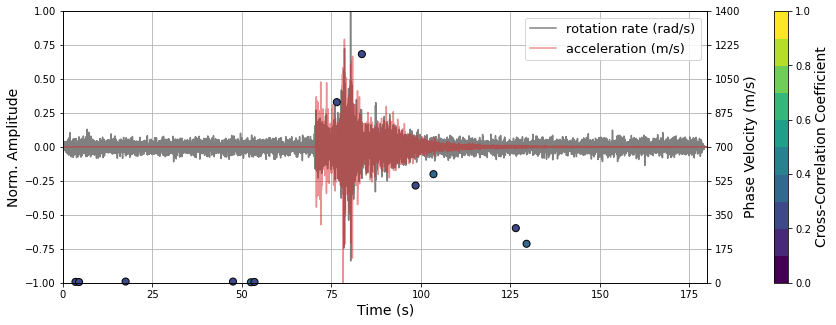

-15


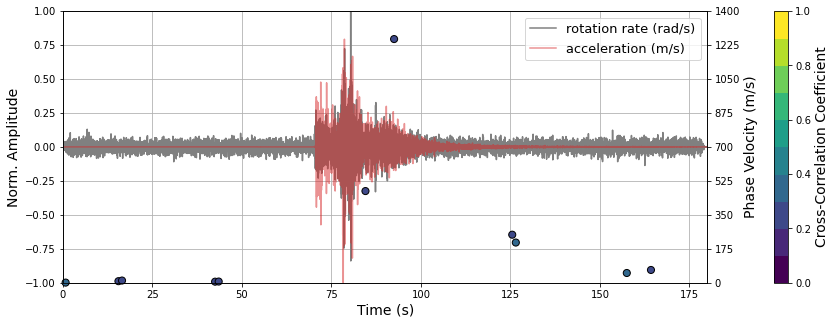

-14


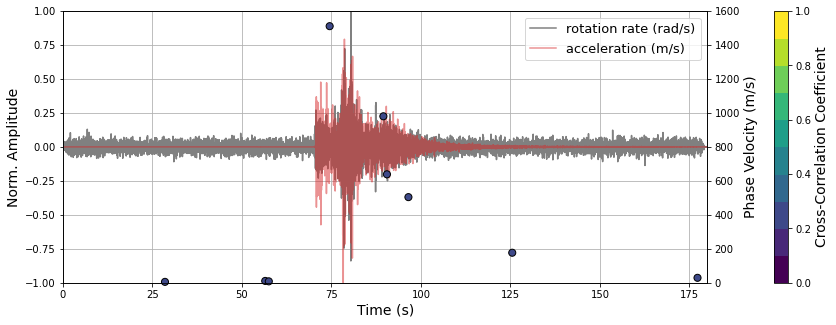

-13


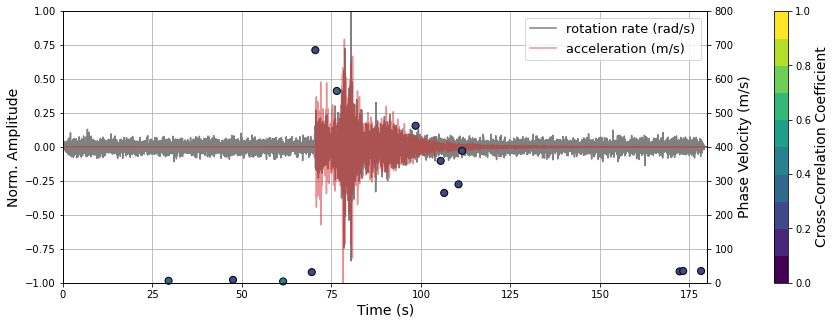

-12


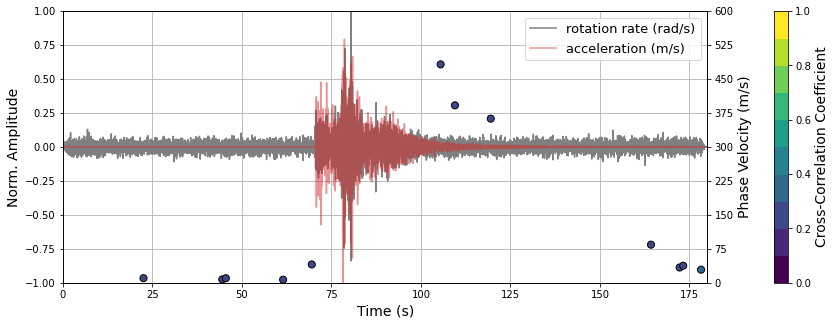

-11


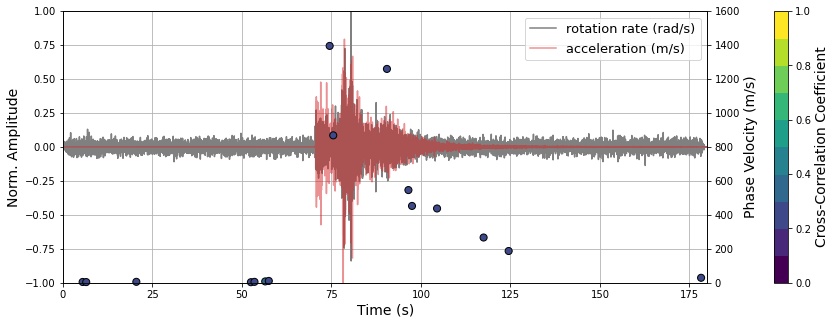

-10


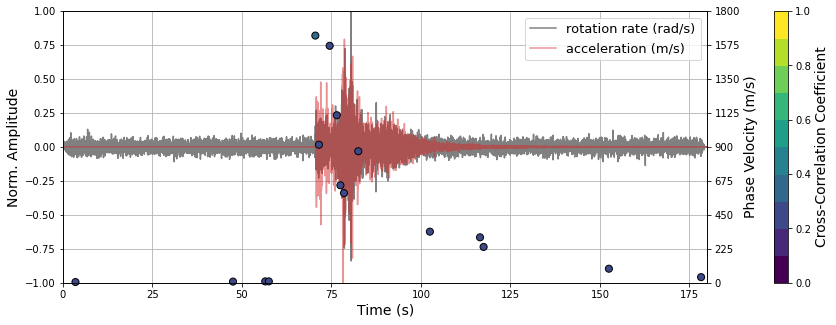

-9


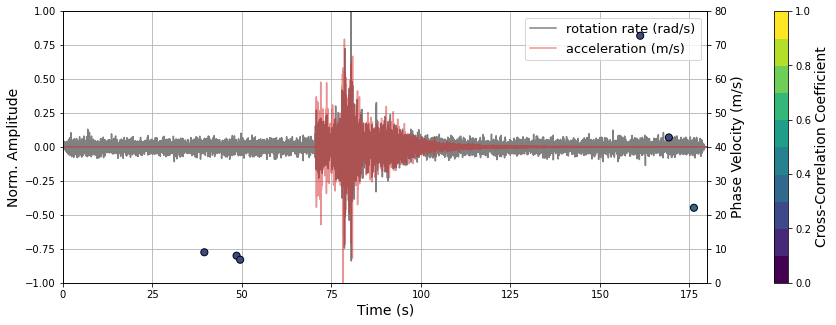

-8


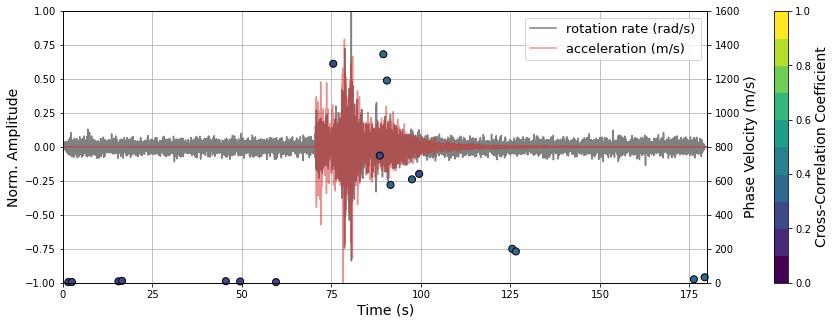

-7


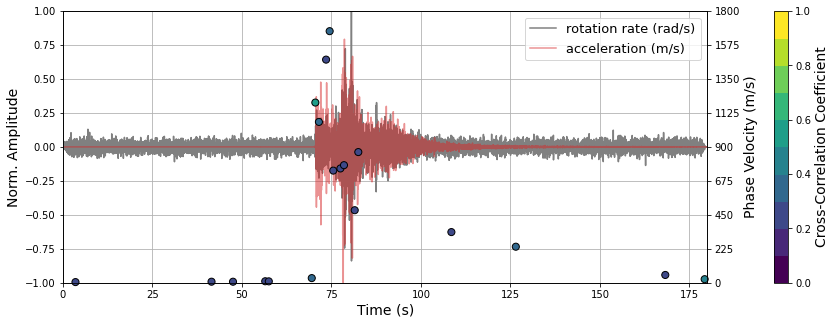

-6


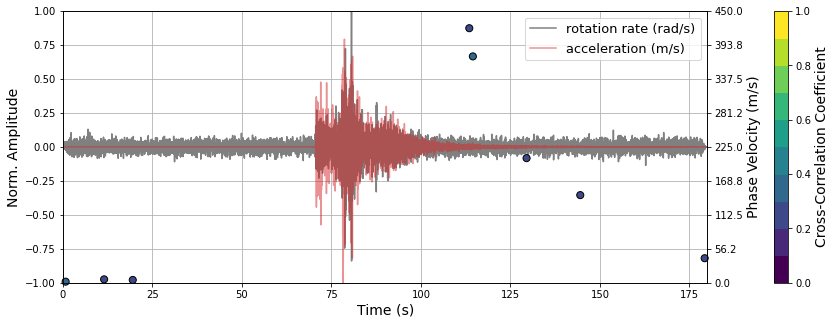

-5


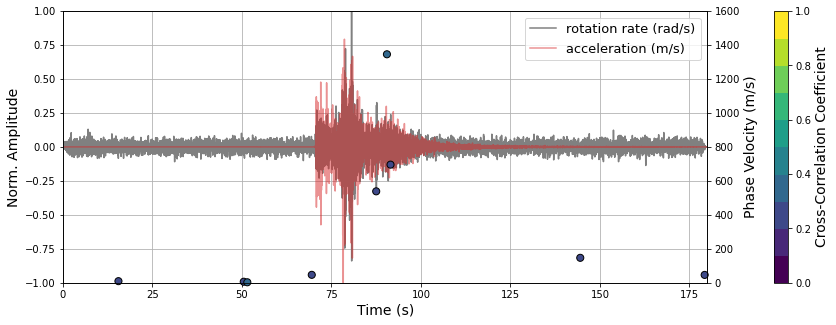

-4


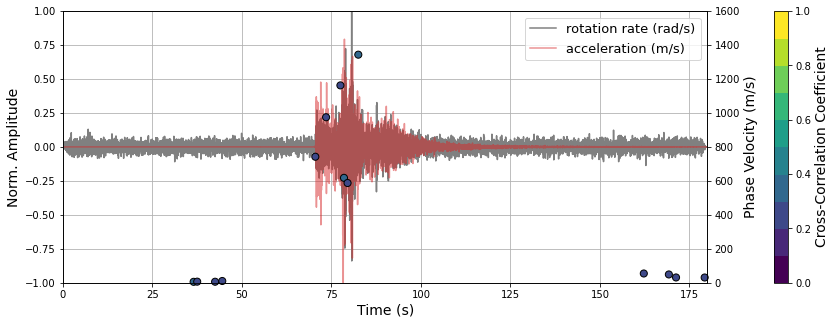

-3


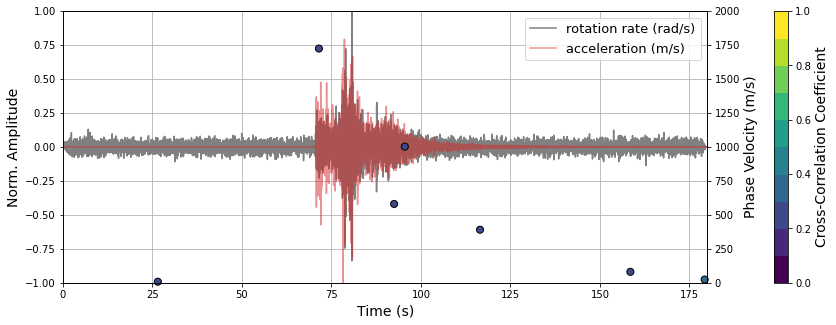

-2


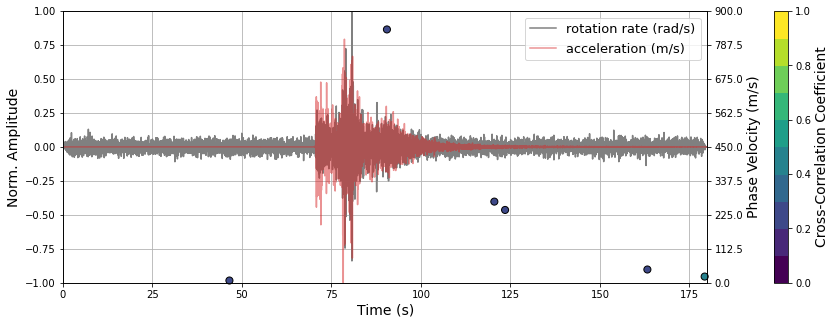

-1


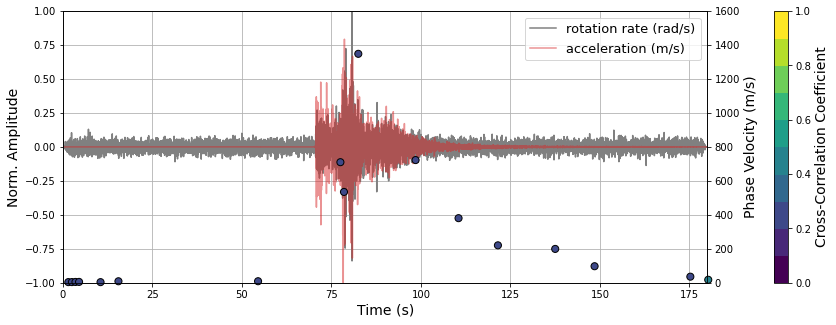

0


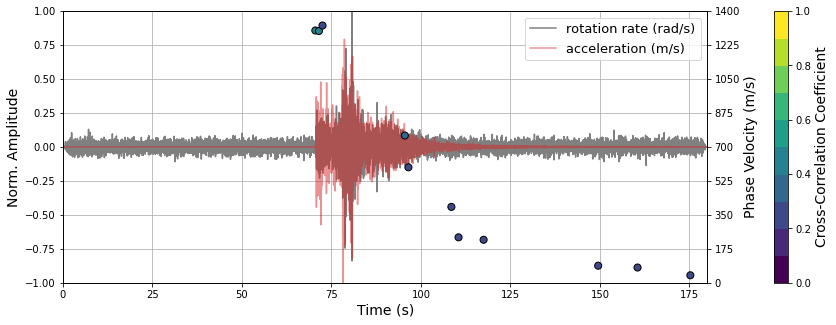

1


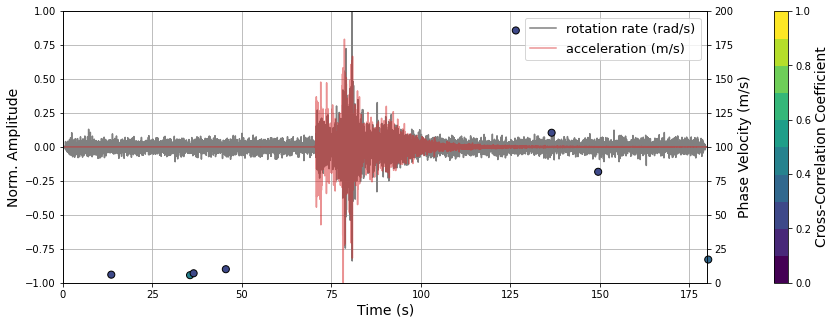

2


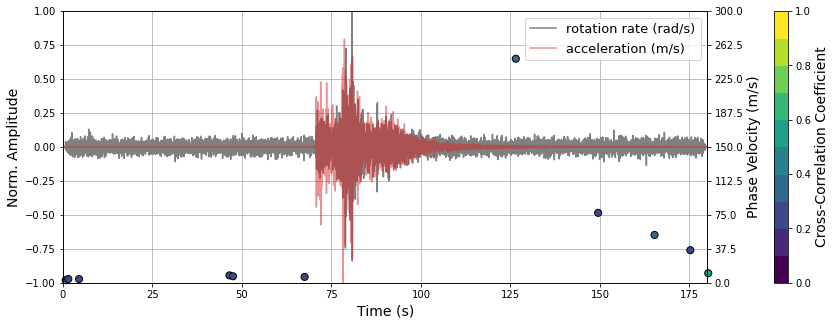

3


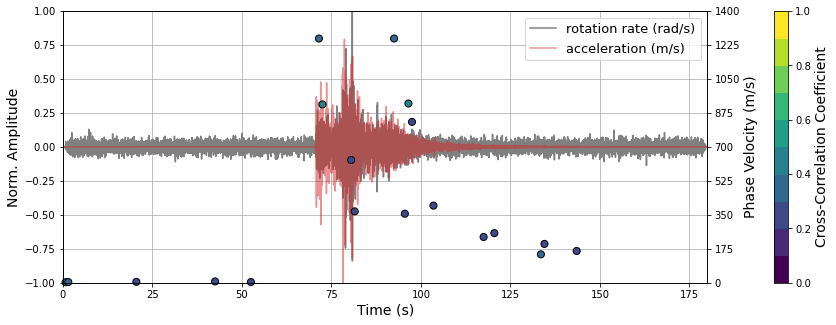

4


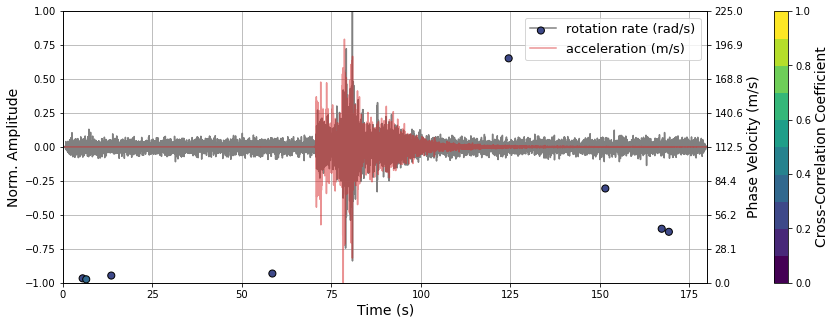

5


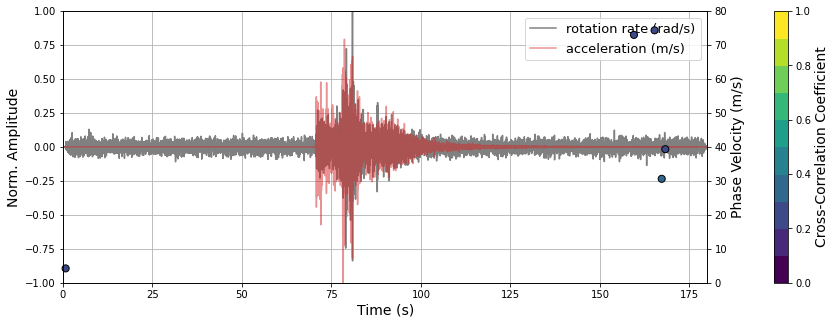

6


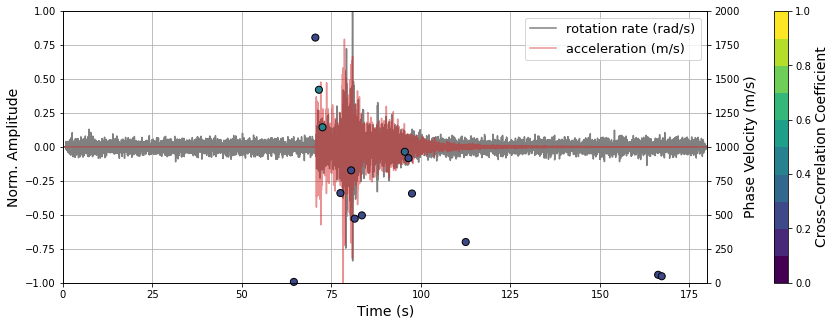

7


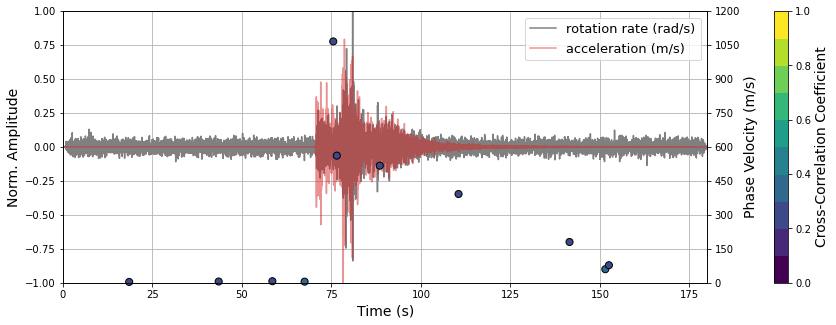

8


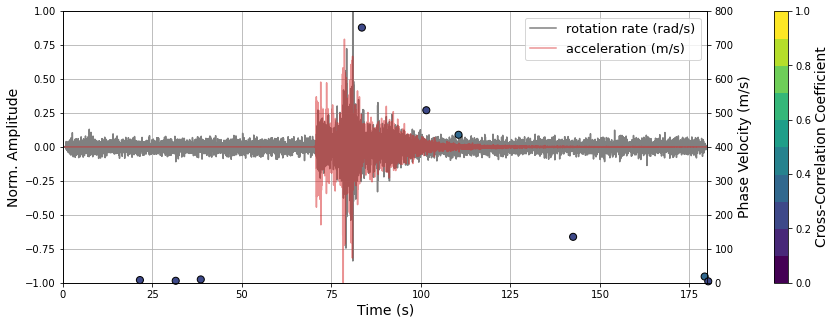

9


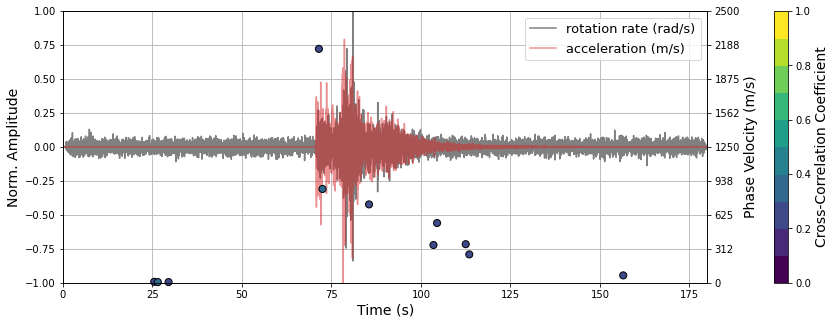

10


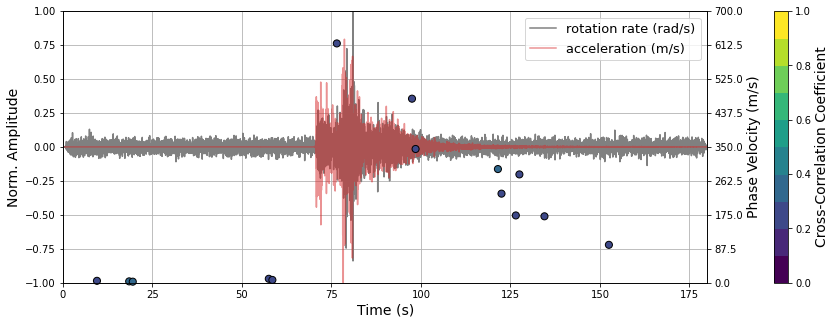

11


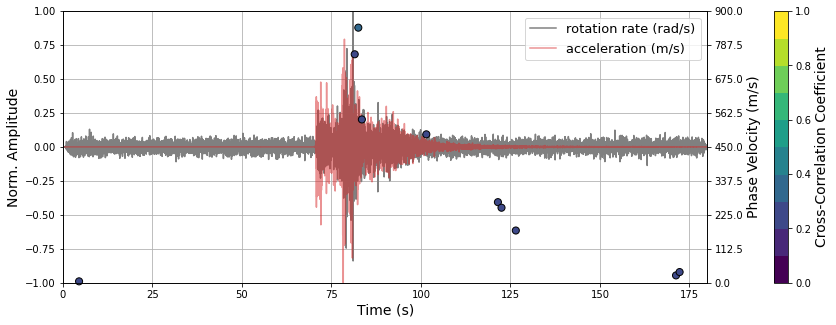

12


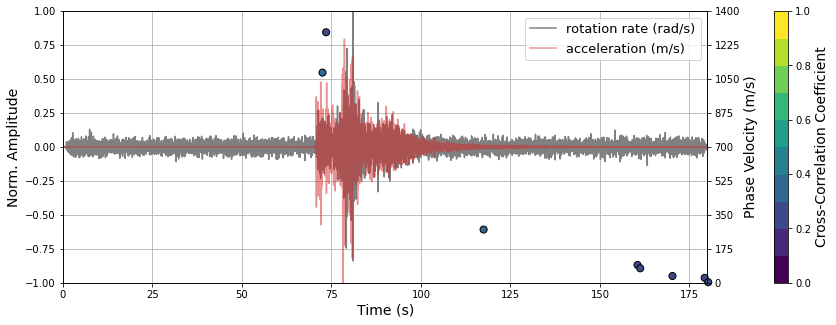

13


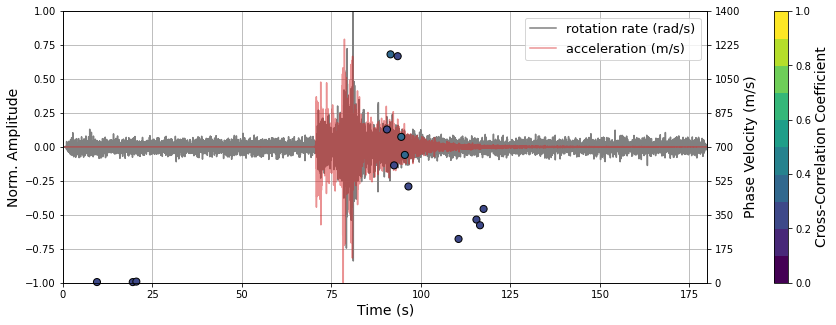

14


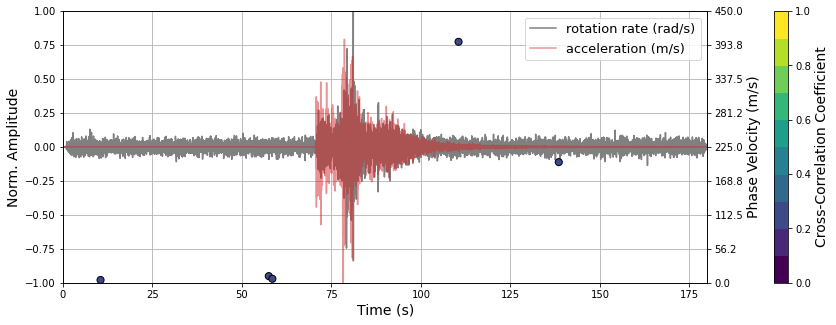

15


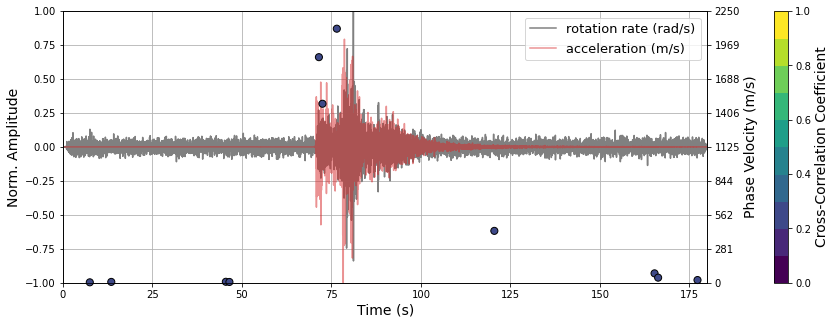

16


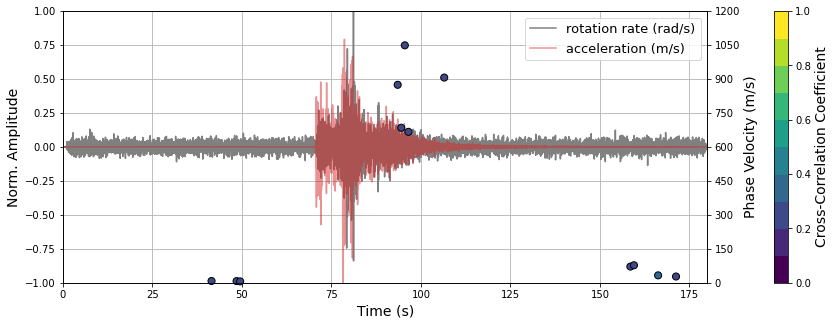

17


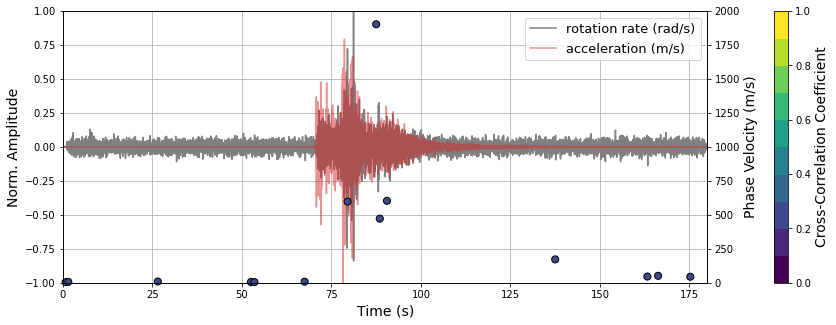

18


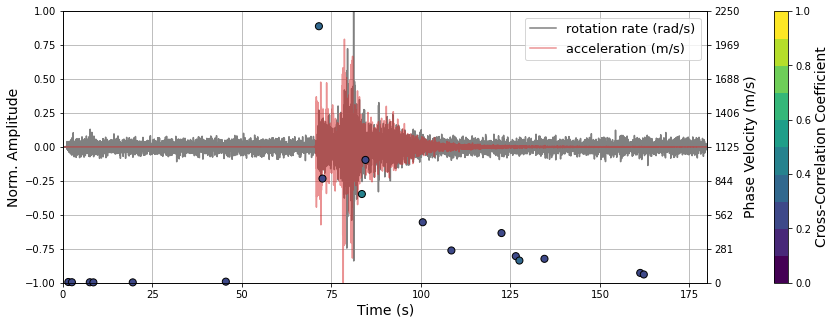

19


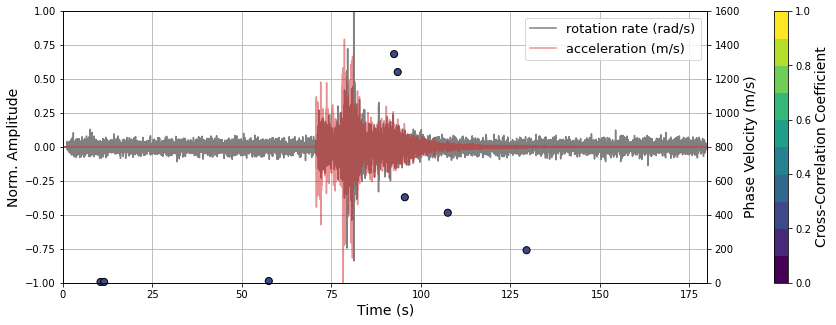

In [772]:
from numpy import roll

for i in range(-20,20):
    print(i)
    rot = roll(t_rot, i)
    t, velocities, ccor = __velocity_from_amplitude_ratio(rot, z_acc, df, win_time_s=1, cc_thres=0.2, overlap=0.5, plot=True)
    plt.show()

In [405]:
def vel_from_amps(rr, acc, event_length, thresh, srate, offset, doplot, model):
    
    from scipy.stats import pearsonr
    import scipy as sp

    win_len = 2.0 # seconds
    win_nsamp = int(win_len * srate)
    cc_thresh = 0.15
    npts = len(rr)
    first = 0
    last = win_nsamp
    start = int(offset)
    stop = int(offset+event_length)
    nwins = int(npts / win_nsamp)
# initialize lists:
    VEL, _VEL, ccorr = np.zeros(nwins), np.zeros(nwins), np.zeros(nwins)
    #VEL, _VEL, ccorr = [], [], []
# we loop over the windows until we reach the end of the trace
    j = 0
    while last < npts:
        r = rr[first:last]
        a = acc[first:last]
        c, p = sp.stats.pearsonr(r, a)
        ccorr[j] = c
        _vel = []
        A = []
        R = []
# we check if the cross-correlation coefficient for this window is larger than 0.9
        if np.abs(c) >= cc_thresh:
            for i in range(len(r)):
# we take only rotation rate values that are above the self-noise
# assuming that acceleration is above self-noise if rotation rate is above self-noise
                if np.abs(r[i]) >= thresh:
                    R.append(r[i])
                    A.append(a[i])
            R = np.asarray(R)
            A = np.asarray(A)
# ODR
            data = RealData(R, A)
            odr = ODR(data, model, beta0=[0., 1.])
            out = odr.run()
            #out.pprint()
            #print(out.beta)
            VEL[j] = np.abs(out.beta[0])
# move to the next window
        first = int(first+win_nsamp)
        last = int(first+win_nsamp)
        j += 1
        
    ccorr = np.asarray(ccorr)
# now we cut out the interesting part of the event
    VEL = np.asarray(VEL)
    _VEL = []
    for val in VEL:
        if val != 0:
            _VEL.append(val)
    _VEL = np.asarray(_VEL)
    vel = np.nanmedian(_VEL)

# We implement the option to plot the analysis step from each single event
    if doplot == True:
        rgba1 = (216/255,27/255,96/255,1)
        rgba3 = (255/255,183/255,7/255,1)

        fig, ax0 = plt.subplots(1, 1, figsize=(6, 5))
        ax1 = ax0.twinx()
        ax0.plot(np.arange(0,len(rr),1)*(1/srate), rr/max(rr), color='r', linewidth=1.5)
        ax0.plot(np.arange(0,len(acc),1)*(1/srate), acc/max(acc), color='k', linewidth=1)
        t_vel = (np.arange(0, len(VEL), 1)) * win_len
        t_corr = np.arange(0, len(ccorr), 1) * win_len
        ax1.plot(t_vel, np.abs(VEL), color=rgba1)
        ax0.plot(t_corr, ccorr, color=rgba3)
        ax0.set_xlim(0,len(rr)*(1/srate))
        ax0.set_ylim(-1.1,1.1)
        #ax1.set_ylim(0, 120)
        ax0.set_xlabel('time [s]')
        ax0.set_ylabel('norm. amp / ccorr')
        ax1.set_ylabel(r'acc/rr [m/s]', color=rgba1)
        ax0.tick_params(axis='x', which='both', direction='in', top=True, bottom=True)
        ax0.tick_params(axis='y', which='both', direction='in', left=True, labelleft=True)
        ax1.tick_params(axis='y', which='both', direction='in', right=True, labelright=True, left=False, labelleft=False, color=rgba1, labelcolor=rgba1)

        plt.show()
    
    print(vel) 
    return vel

/home/brotzer/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


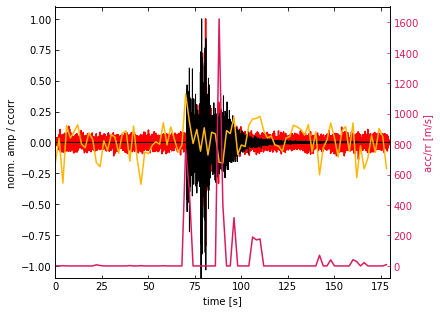

40.2215464901


In [770]:
from scipy.odr import *


def linear_func(p, x):
    m, c = p
    return m*x +c

linear_model = Model(linear_func)

vel = vel_from_amps(t_rot, z_acc, len(z_acc), 1e-7, 40, 0, True, linear_model)

## Testing Signal-to-Noise ratios

In [98]:
# from numpy import nanmean, sqrt

# win_length_sec = 10 ## seconds

# t_trigger = events.trigger_time[jj]
# t_rel_sec = t_trigger-config['tbeg']
# fig, ax = plt.subplots(len(st0),1, figsize=(15,15))

# for i, tr in enumerate(st0):
    
#     df = tr.stats.sampling_rate 
    
#     NN = int(df * win_length_sec) ## samples
    
#     t_rel_spl = t_rel_sec*df ## samples
    
#     t_offset = df * 2 ## samples
    
#     noise = nanmean(tr.data[int(t_rel_spl-NN):int(t_rel_spl)]**2)
#     signal = nanmean(tr.data[int(t_rel_spl):int(t_rel_spl+NN)]**2)
    
#     SNR = sqrt(signal/noise)
    
    
       
#     ax[i].plot(tr.data)
    
#     ax[i].axvline(t_rel_spl, color="red")
#     ax[i].axvline(t_rel_spl+NN, color="red")

#     ax[i].axvline(t_rel_spl, color="g")
#     ax[i].axvline(t_rel_spl-NN, color="g")

#     print(SNR)
    
# plt.show();    


## Test Back Azimuth

In [99]:
from functions.compute_backazimuth import __compute_backazimuth

3 Trace(s) in Stream:
II.PFO.10.BHE | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples
II.PFO.10.BHN | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples
II.PFO.10.BHZ | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-10-07T22:44:05.472300Z - 2022-10-07T22:47:05.472300Z | 40.0 Hz, 7201 samples
PY.BSPF..HJN | 2022-10-07T22:44:05.472300Z - 2022-10-07T22:47:05.472300Z | 40.0 Hz, 7201 samples
PY.BSPF..HJZ | 2022-10-07T22:44:05.472300Z - 2022-10-07T22:47:05.472300Z | 40.0 Hz, 7201 samples

 -> 2 events found!!!
2 Event(s) in Catalog:
2022-10-08T02:59:57.560000Z | +35.940,  -97.889 | 1.7 ml | manual
2022-10-08T02:59:39.290000Z | +33.487, -116.502 | 1.08 ml | manual


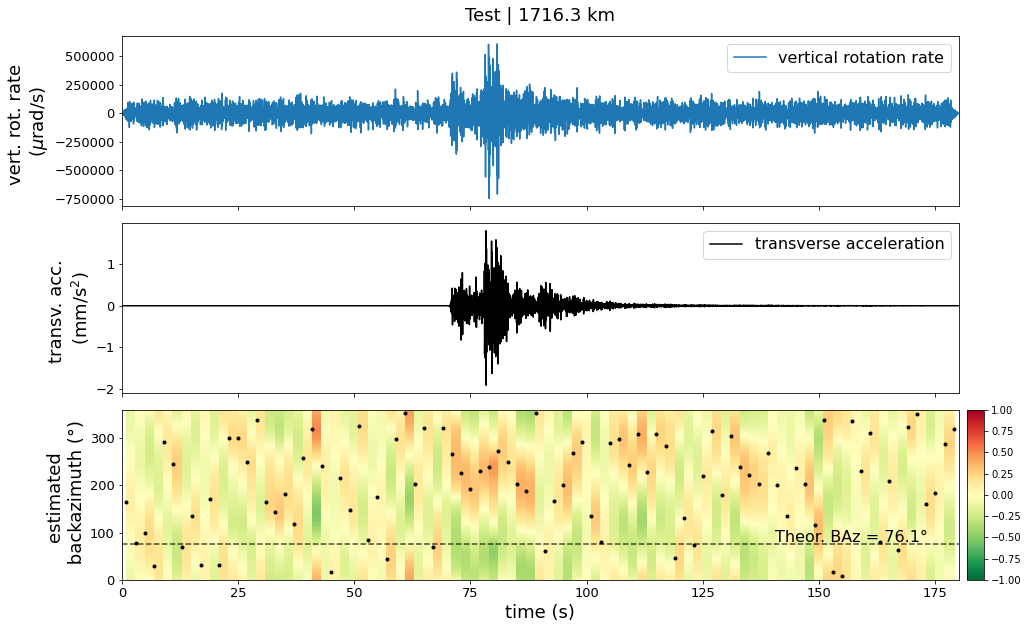

{'baz_mesh': [array([[   1.,    3.,    5., ...,  175.,  177.,  179.],
         [   1.,    3.,    5., ...,  175.,  177.,  179.],
         [   1.,    3.,    5., ...,  175.,  177.,  179.],
         ..., 
         [   1.,    3.,    5., ...,  175.,  177.,  179.],
         [   1.,    3.,    5., ...,  175.,  177.,  179.],
         [   1.,    3.,    5., ...,  175.,  177.,  179.]]),
  array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   2.,    2.,    2., ...,    2.,    2.,    2.],
         [   4.,    4.,    4., ...,    4.,    4.,    4.],
         ..., 
         [ 354.,  354.,  354., ...,  354.,  354.,  354.],
         [ 356.,  356.,  356., ...,  356.,  356.,  356.],
         [ 358.,  358.,  358., ...,  358.,  358.,  358.]])],
 'baz_corr': array([[ -9.44771516e-02,   8.79487213e-03,  -7.07154476e-03, ...,
          -7.54749086e-02,   6.27590228e-02,   1.54388389e-01],
        [ -9.32344768e-02,   1.17967787e-02,   2.04694523e-03, ...,
          -7.56101286e-02,   5.56377702e-02, 

In [229]:
st_acc = st.select(station="PFO").copy()
st_rot = st.select(station="BSPF").copy()

st_acc.filter('bandpass', freqmin=4, freqmax=15, zerophase=True, corners=4)
st_rot.filter('bandpass', freqmin=4, freqmax=15, zerophase=True, corners=4)

config2 = {}
config2['tbeg'] = st_acc[0].stats.starttime
config2['tend'] = st_acc[0].stats.endtime
config2['station_latitude'] = config['BSPF_lat']
config2['station_longitude'] = config['BSPF_lon']
config2['step'] = 2
config2['win_length_sec'] = 2.
config2['overlap'] = 0.1
config2['eventtime'] = obs.UTCDateTime(out_df['Torigin'].iloc[jj])
config2['title'] = "Test"

__compute_backazimuth(    
                        st_acc,
                        st_rot,
                        config2,
                        wave_type='love',
                        event=None,
                        plot=True,
                        show_details=False,
                      )


## CC for f-bands

In [201]:
fmin, fmax = 1, 20

def __cc_in_octaves(st_in, fmin, fmax):

    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from functions.compute_cc_for_fbands import __compute_cc_for_fbands
    
    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")

    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    ## _____________________

#     fbands = [(1,5),(2,6),(3,7),(4,8),(5,9),(6,10),(7,11),(8,12),(9,13),(10,14),(11,15),(12,16),(13,17),(14,18)]
#     fbands = [(1,2),(2,4),(3,6),(4,8),(5,10),(6,12),(7,14),(8,16), (9,18), (10,20)]

    df_out = DataFrame()
    
    for comp in ["Z","N","E"]:

        print(comp)

        plt.figure(figsize=(15,5))

        tr1 = st_in.select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}')[0]
        
        
        ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr2, fbands=fbands, plot=False)
        
        df_out[f'{comp}_in_fband'] = ff
        df_out[f'{comp}_in_cc_t'] = cc_t_max
        df_out[f'{comp}_in_cc_f'] = cc_f_max
        
        plt.scatter(ff, cc_t_max, color="r")
        plt.scatter(ff, cc_f_max, color="r")

        ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr3, fbands=fbands, plot=False)

        df_out[f'{comp}_al_fband'] = ff
        df_out[f'{comp}_al_cc_t'] = cc_t_max
        df_out[f'{comp}_al_cc_f'] = cc_f_max
        
        plt.scatter(ff, cc_t_max)
        plt.scatter(ff, cc_f_max) 

    #     plt.xscale("log")
        plt.show()
        
    return df_out

Z


/home/brotzer/anaconda3/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (22.44924096618746) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


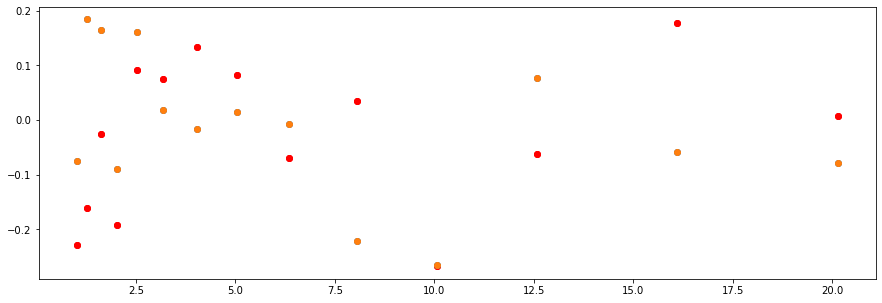

N


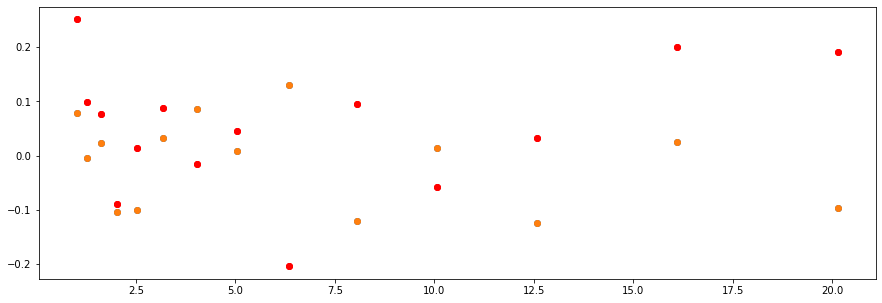

E


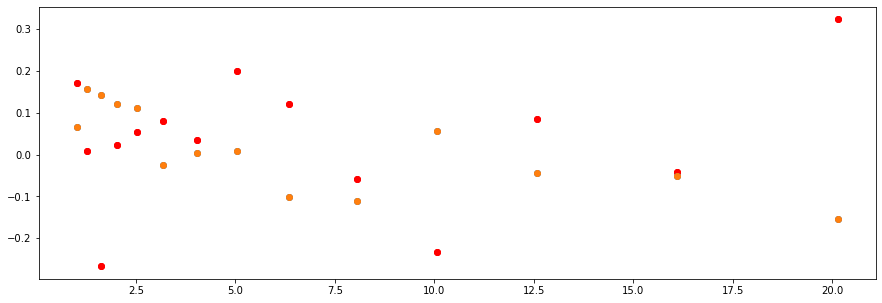

,Z_in_fband,Z_in_cc_t,Z_in_cc_f,Z_al_fband,Z_al_cc_t,Z_al_cc_f,N_in_fband,N_in_cc_t,N_in_cc_f,N_al_fband,N_al_cc_t,N_al_cc_f,E_in_fband,E_in_cc_t,E_in_cc_f,E_al_fband,E_al_cc_t,E_al_cc_f
0,1.006680,-0.228544,-0.228544,1.006680,-0.075330,-0.075330,1.006680,0.251311,0.251311,1.006680,0.078986,0.078986,1.006680,0.171321,0.171321,1.006680,0.065331,0.065331
1,1.258350,-0.160759,-0.160759,1.258350,0.184213,0.184213,1.258350,0.099194,0.099194,1.258350,-0.004822,-0.004822,1.258350,0.007758,0.007758,1.258350,0.156487,0.156487
2,1.610689,-0.025783,-0.025783,1.610689,0.164771,0.164771,1.610689,0.077001,0.077001,1.610689,0.023348,0.023348,1.610689,-0.267371,-0.267371,1.610689,0.141704,0.141704
3,2.013361,-0.192755,-0.192755,2.013361,-0.089415,-0.089415,2.013361,-0.088700,-0.088700,2.013361,-0.103172,-0.103172,2.013361,0.023781,0.023781,2.013361,0.121574,0.121574
4,2.516701,0.091387,0.091387,2.516701,0.160733,0.160733,2.516701,0.015025,0.015025,2.516701,-0.099250,-0.099250,2.516701,0.054416,0.054416,2.516701,0.110103,0.110103
5,3.171043,0.075597,0.075597,3.171043,0.018651,0.018651,3.171043,0.087358,0.087358,3.171043,0.031803,0.031803,3.171043,0.080339,0.080339,3.171043,-0.024737,-0.024737
6,4.026722,0.132917,0.132917,4.026722,-0.016640,-0.016640,4.026722,-0.016150,-0.016150,4.026722,0.087006,0.087006,4.026722,0.035152,0.035152,4.026722,0.003199,0.003199
7,5.033402,0.082995,0.082995,5.033402,0.014211,0.014211,5.033402,0.045402,0.045402,5.033402,0.009192,0.009192,5.033402,0.200586,0.200586,5.033402,0.009028,0.009028
8,6.342086,-0.069637,-0.069637,6.342086,-0.007066,-0.007066,6.342086,-0.204018,-0.204018,6.342086,0.130575,0.130575,6.342086,0.121800,0.121800,6.342086,-0.100782,-0.100782
9,8.053443,0.034804,0.034804,8.053443,-0.222129,-0.222129,8.053443,0.095981,0.095981,8.053443,-0.121108,-0.121108,8.053443,-0.058308,-0.058308,8.053443,-0.110527,-0.110527


In [202]:
df_cc = __cc_in_octaves(st, fmin, fmax)
df_cc

### Correlatio matrix

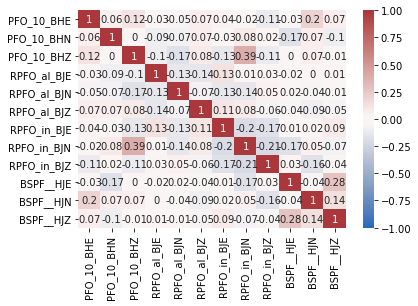

In [190]:
import seaborn as sns

dff = __stream_to_dataframe(st)

matrix = dff.corr().round(2)

sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')

In [596]:
def __coherence_in_octaves(st_in, fmin, fmax):

    from numpy import arange, mean
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from scipy.signal import coherence
    
    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")
    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    ## _____________________

#     ddf = 3
#     fcenter = arange(fmin+ddf, fmax-ddf, 1)
#     fbands = [(fc - ddf, fc + ddf) for fc in fcenter] 
    
    df_out = DataFrame()
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    
    for ii, comp in enumerate(["Z","N","E"]):

        tr1 = st_in.select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}')[0]
        
        co2, co3 = [],[]
        for (fl, fu) in fbands:
            s1, s2, s3 = tr1.copy(), tr2.copy(), tr3.copy()
            
            s1 = s1.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s2 = s2.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s3 = s3.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            
            s1 = s1.normalize()
            s2 = s2.normalize()
            s3 = s3.normalize()

            s1 = s1.taper(0.1)
            s2 = s2.taper(0.1)
            s3 = s3.taper(0.1)
            
            df = s1.stats.sampling_rate
            tseg = 1/fl*20
            nseg = int(df*tseg)
            
#             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann',nperseg=nseg, noverlap=int(0.5*nseg))
#             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann',nperseg=nseg, noverlap=int(0.5*nseg))
            ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann')
            ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann')
        
            for i in range(len(ff2)):
                if ff2[i] < fl or ff2[i] > fu:
                    coh2[i], coh3[i] = 0, 0
        
#             plt.figure()
#             plt.plot(ff2, coh2)
#             plt.show()
            
            co2.append(max(coh2))
            co3.append(max(coh3))
            
        df_out[f'{comp}_in_fc'] = fcenter
        df_out[f'{comp}_in_co']  = co2
        df_out[f'{comp}_al_fc'] = fcenter
        df_out[f'{comp}_al_co']  = co3
                 
        ax[ii].scatter(fcenter, co2, s=50, label="BSPF-RPFO_inner")
        ax[ii].plot(fcenter, co2, ls="-")

        ax[ii].scatter(fcenter, co3, s=50, label="BSPF-PRFO_all")
        ax[ii].plot(fcenter, co3, ls="-")

        ax[ii].set_title(f"max. coherence {comp}")
        ax[ii].legend()
        ax[ii].set_xscale("log")
        ax[ii].grid(ls="--",zorder=0,alpha=.5, which="both")
    plt.show();
        
    return df_out

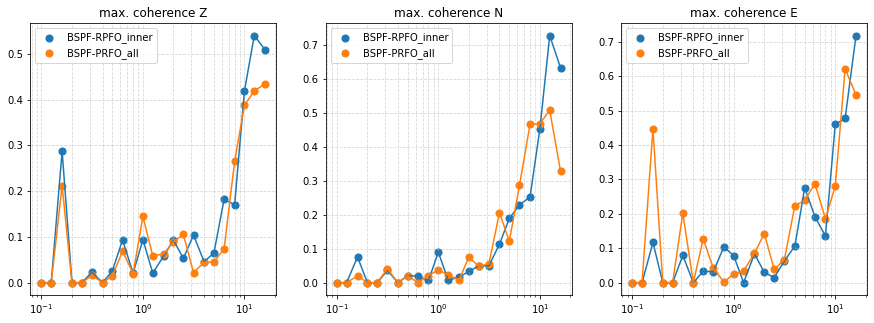

In [597]:
fmin, fmax = 0.1,15

df_coh = __coherence_in_octaves(st, fmin, fmax)

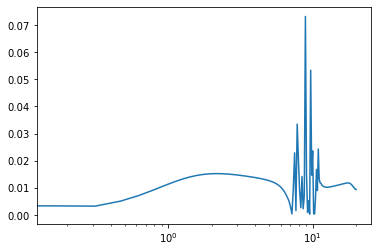

In [533]:
s1, s2, s3 = tr1.copy(), tr2.copy(), tr3.copy()

fl=8
fu=10


s1 = s1.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
s2 = s2.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
s3 = s3.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)

s1 = s1.normalize()
s2 = s2.normalize()
s3 = s3.normalize()

ff, co = coherence(    
                    s1,
                    s2,
                    fs=40.0,
                    window='hann',
                    nperseg=None,
                    noverlap=None,
                    nfft=None,
                    detrend='constant',
                    axis=-1,
)

plt.semilogx(ff,co)

## Manual Selection

In [252]:
date = UTCDateTime("2023-05-20")
events[(events.origin < str((date+86500).date)) & (events.origin > str((date).date))]

,index,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km,Hdistance_km
251,287,2023-05-20 08:18:16.240,33.382167,-116.906667,12640.0,3.38,ml,19988296.24,2023-05-20T08:18:24.570000Z,2023-05-20T08:18:27.610016Z,2023-05-20T08:18:16.240000Z,6.0,58.728876,48.993538,50.597790
252,288,2023-05-20 08:20:51.820,33.381833,-116.904000,13440.0,2.61,ml,19988451.82,2023-05-20T08:21:00.140000Z,2023-05-20T08:21:03.342305Z,2023-05-20T08:20:51.820000Z,6.0,58.542019,48.800911,50.617808


In [254]:
good_events = [
    "2022-10-03 16:08:09.970",
    "2022-10-07 22:45:05.470",
    "2022-10-15 05:17:34.150",
    "2022-10-23 09:24:58.150",
    "2022-10-26 08:14:35.080",
    "2022-12-31 12:12:26.650",
    "2023-01-09 19:42:56.460",
    "2023-01-11 18:59:20.030",
    "2023-01-15 09:58:54.070",
    "2023-02-01 09:05:02.320",
    "2023-03-01 22:49:03.580",
    "2023-03-24 13:45:13.700",
    "2023-04-10 14:51:00.950",
    "2023-04-17 18:52:36.930",
    "2023-04-26 06:46:58.450",
    "2023-05-03 21:14:20.210",
    "2023-05-20 08:18:16.240",
]

df = pd.DataFrame()
df['origin_time'] = good_events
# df.to_pickle(config['outpath_data']+"event_selection_good.pkl")

In [255]:
from obspy import UTCDateTime

## list of events to reject (manually)
no_event = ["2022-10-05 15:39:13.690", 
            "2022-10-05 15:42:03.610",
            "2022-10-05 18:35:16.860",
            "2022-10-10 05:48:52.890",
            "2022-10-12 19:12:14.670",
            "2022-10-12 23:08:11.410",
            "2022-10-12 23:58:00.800",
            "2022-10-14 03:13:56.380",
            "2022-10-16 08:42:24.970",
            "2022-10-26 08:27:09.860",
            "2022-10-28 12:47:26.910",
            "2022-11-03 05:53:34.230",
            "2022-11-09 00:46:57.550",
            "2022-11-10 16:53:29.940",
            "2022-11-25 10:45:36.390",
            "2022-12-06 21:56:31.330",
            "2022-12-09 06:03:03.220",
            "2022-12-15 13:55:13.460",
            "2022-12-17 18:02:34.910",
            "2022-12-19 15:41:22.380",
            "2022-12-19 15:41:26.020",
            "2023-01-05 09:59:04.210",
            "2023-01-07 12:32:45.250",
            "2023-01-16 00:00:36.100",
            "2023-01-29 23:50:47.770",
            "2023-02-05 23:38:46.670",
            "2023-02-22 05:09:39.970",
            "2023-03-09 11:49:06.640",
            "2023-03-17 07:12:56.970",
            "2023-03-24 13:59:00.160",
            "2023-03-29 19:23:29.470",
            "2023-03-29 19:23:27.460",
            "2023-04-06 02:42:00.600",
            "2023-04-13 23:57:53.950",
            "2023-04-17 15:27:56.450",
            "2023-05-01 02:52:56.160",
            "2023-06-02 20:19:46.740",
            "2023-06-05 07:39:16.650",
           ]

no_event_utc = list(map(UTCDateTime, no_event))


df = pd.DataFrame()
df['origin_time'] = no_event
# df.to_pickle(config['outpath_data']+"event_selection_reject.pkl")